In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from math import ceil
from copy import copy

#Nice graphics
plt.style.use('ggplot')

In [2]:
#
# Some utilities
#
def pick_random_list(l):
    """
        Prend un élément au hasard dans une liste
    """
    return l[np.random.randint(0,len(l))]


def pick_random(X, n = 1):
    """
        Extrait n lignes aléatoires d'un array avec remise
    """
    return X[np.random.randint(0,len(X), int(n))]


def dist(m):
    """
        Give the euclidian distance of a walk
    """
    return np.linalg.norm(m[0]-m[len(m) - 1])


def plot(m):
    """
        Plot a walk
    """
    plt.figure()
    plt.grid(True)
    plt.axis("equal")
    plt.plot(m[:,0], m[:,1], color="red")
    plt.title("Walk of " + str(len(m)) + " steps")
    plt.scatter(m[0,0], m[0,1], color="black", marker="x", s=300)
    plt.scatter(m[len(m)-1,0], m[len(m)-1,1], color="black", marker="x", s=300)
    
    
def is_maae(X):
    """
        Return true if the walk is self avoiding
    """
    return np.unique(X, axis=0).shape[0] == X.shape[0]


def count_MAAE(X):
    """
        Return the number of self avoiding walk in X
    """
    i = 0
    for x in X:
        if is_maae(x): i += 1
    return i

# Builders

## Just random walk

In [3]:
def build_ma(n, l, d = 2):
    """
        Build n random walk of length l in d dimension
    """    
    n, l, d = int(n), int(l), int(d)
    
    k = l+1 # Number of trajectory points
    directions = np.concatenate((np.identity(d), -np.identity(d))).astype(np.int8) # Possible movement

    # Generate MAs
    X = pick_random(directions, n*k) # Generate more because concatenation is more heavy
    X = X.cumsum(axis=0).reshape((n,k,d))
    X -= np.repeat(X[:,0,:] ,k, axis=0).reshape((n,k,d)) # Normalizing to (0,0)
    
    return X

<IPython.core.display.Javascript object>


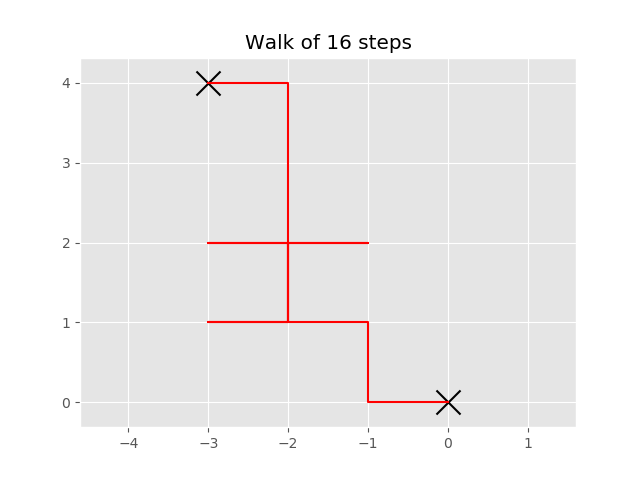

In [4]:
m = build_ma(1, 15)[0]
plot(m)

## Méthode 1

In [5]:
def build_maae(l_max = 100, d = 2):
    """
        Build an MAAE (no length fixed, can sometimes be blocked before finishing)
    """    
    
    m, p = [[0]*d], 1.0
    directions = np.concatenate((np.identity(d), -np.identity(d))).astype(np.int8) #possibités de déplacement sans contraintes
    for l in range(l_max):
        last_pos = m[len(m) - 1]
        new_pos = last_pos + directions
        
        # Checking position
        pos_available = []
        for pos in new_pos.tolist():
            if pos not in m:
                pos_available.append(pos)
        
        #Handling proba
        n_pos = len(pos_available)
        if (n_pos == 0):
            break
        else:
            p *= 1/float(n_pos)
        
        # Picking random one
        next_pos = pick_random_list(pos_available)
        m.append(next_pos)
    
    return np.array(m), p

In [6]:
def build_maae_l(l, d = 2, iter_max=1000):
    """
        Build an MAAE with a fixed length
        returns the walk, its probability and the selection frequency of the process
    """    
    
    for i in range(iter_max):
        m, p = build_maae(l_max = l, d = d)
        if (len(m) == l+1):
            return m, p, float(1)/float((i+1))
    raise ValueError(str(l) + " length is too far to reach in " + str(d) +" dimension. ("+str(iter_max)+" iterations)")

## Reject method

In [7]:
def build_n_maae_reject(n, l, d = 2, iter_max = 100, N_patch = 10E3):
    X_maae, n_done = [], 0
    for _ in range(iter_max):
        n_to_do = n - n_done

        X = build_ma(N_patch, l)

        #Check if is MAAE
        is_maae_mask = np.zeros((len(X)), dtype = np.bool)
        for i, x in enumerate(X):
            if is_maae(x):
                X_maae.append(x)
                n_done += 1
                
                if n_done == n:
                    return X_maae
                    
    raise ValueError("The lenght is too big to generate "+str(n)+" MAAE efficiently with the reject method (Too many iteration).")

In [12]:
X = build_ma(100, 5, d= 15)
Rcount_MAAE(X)

86

In [13]:
import pandas as pd

<IPython.core.display.Javascript object>


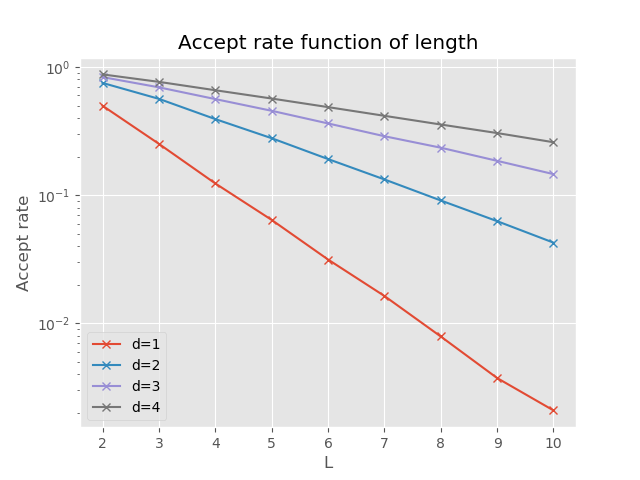

In [41]:
def plot_accept_rate(N_patch=10E3, l_max = 10, d_max = 4):
    """
        Plot accept rate for walk with l_max and d_max
    """
    D = range(1, d_max+1)
    L = range(2, l_max+1)

    plt.figure()
    plt.title("Accept rate function of length")
    plt.xlabel("L")
    plt.ylabel("Accept rate")
    for d in D:
        R = np.zeros(len(L))
        for j, l in enumerate(L):
            X = build_ma(N_patch, l, d)
            R[j] = count_MAAE(X)/N_patch 
        plt.semilogy(L, R, label="d="+str(d), marker="x")
    plt.legend()
    
plot_accept_rate(N_patch=10E4)

## Rotation method

In [8]:
import time
from copy import copy

def reflex_sym(part_walk, angle):
    
    #starting point
    point = part_walk[0]
    
    #define the corresponding rotation matrix
    R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    
    #start to set the origin at the starting point
    centered_walk = part_walk - point
    
    #apply rotation
    rotated_walk = np.dot(R, np.transpose(centered_walk))
    
    #dectenter
    final_walk = np.transpose(rotated_walk) + point
    
    return np.rint(final_walk)

def maae_roation_sym(N, l):
    init_walk = build_n_maae_reject(1, l, d=2)
    
    whole_walk_new = init_walk[0]
    
    start = time.time()
    
    for _ in range(N):
        
        k = np.random.choice(np.arange(l), 1)[0]

        part_walk = copy(whole_walk_new[k:])

        a = np.random.randint(2)

        if a == 0:
            new_part_walk = reflex_sym(part_walk, angle = np.pi/2)

        else:
            new_part_walk = reflex_sym(part_walk, angle = 3*np.pi/2)
        
        possible_walk_new = np.concatenate((whole_walk_new[:k], new_part_walk))

        if is_maae(possible_walk_new):
            whole_walk_new = possible_walk_new
            
    end = time.time()
    
    return whole_walk_new, end-start

Execution time : 0.2187206745147705


<IPython.core.display.Javascript object>


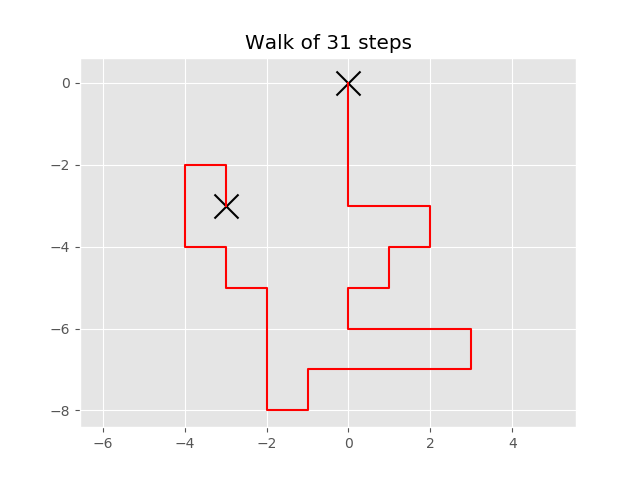

In [9]:
m, comp_time = maae_roation_sym(3000, l=30)
print("Execution time : " + str(comp_time))
plot(m)

# Estimators

In [10]:
def mean_d_IS(l, n = 10000, d = 2):
    """
        Estimator of the mean distance of a MAAE
        with Importance Sampling
    """
    
    D = np.zeros(n)
    S = np.zeros(n)
    for i in range(n):
        m, p, accept_rate = build_maae_l(l, d)
        D[i] = dist(m)
        S[i] = 1/p
    
    estimated_average_distance = np.sum(D*S)/np.sum(S)
    estimated_variance = (n*np.sum(np.square(S)*np.square(D-estimated_average_distance)))/(np.sum(S))**2
    
    return  estimated_average_distance, estimated_variance

In [11]:
def mean_d_reject_IS(l, n=10000, d = 2):
    """
        Estimator of the mean distance of a MAAE
        with reject method
    """
    
    D = np.zeros(n)
    m = build_n_maae_reject(n, l, d = 2)
    for i in range(n):
        D[i] = dist(m[i])
        
    estimated_average_distance = np.mean(D)
    estimated_variance = np.var(D)
    return estimated_average_distance, estimated_variance

## Utilities for analysis

This classes enables an efficient storing of the heavy computing.<br>
You can plot quickly the data related to your estimator.<br>
An estimator must have the parameters l, n, d and return the distance and variance estimated.

In [12]:
import os.path
from time import time

class Estimator_Metric:
    """
        Enables the storage of estimators.
        Mainly a cache to save time.
        Estimator data are saved in folder data automatically.
    """
    
    def __init__(self, estimator, N, n, l, d = 2, use_cache = True):
        self.estimator = estimator # Estimator to use
        self.N = N # Number of estimator
        self.n = n # Number of walk by estimator
        self.l = l # Length of walk
        self.d = d # Dimension of walk
        
        self.name = self.estimator.__name__ + "_" + "_".join([str(n), str(l), str(d)])
        self.path = "data/" + self.name + ".npy"
        
        self._run(use_cache)
        
    def _run(self, use_cache):
        # Handle the cache
        cache = self._get_cache()[:self.N] if use_cache  else np.zeros((0,3))
        n_to_do = self.N - len(cache)
        
        # Print processing if necessary because its really heavy
        if (n_to_do > 0): print("Building " + str(n_to_do) + " walks for '"+self.path+"'...")
        
        # Generate new data (if needed)
        new_data = np.zeros((n_to_do, 3))
        n, l, d = self.n, self.l, self.d #Shortcut
        for i in range(n_to_do):
            t = time()
            new_data[i] = self.estimator(l=l, n=n, d=d) + (time()-t,)
        
        # Append the new data and the cache
        self.data = np.append(cache, new_data, axis = 0)
        
        #Save if cache used
        if use_cache: self._save()
        
        return self
            
    def _get_cache(self):
        return np.load(self.path) if (os.path.isfile(self.path)) else np.zeros((0,3))
        
        
    def _save(self):
        cache = self._get_cache()
        if (len(cache) < len(self.data)):
            np.save(self.path, self.data)
        return self
    
    def get_D(self):
        return self.data[:, 0]
    
    def get_V(self):
        return self.data[:, 1]
    
    def get_T(self):
        return self.data[:, 2]

    
    
        
class EstimatorPlot():
    """
        This class plot for an estimator its characteristic
    """
    
    def __init__(self, estimator, N = 10, n = 1000, d = 2, label = None, color="blue"):
        self.estimator = estimator
        self.n = n
        self.d = d
        self.N = N
        self.label = estimator.__name__ if label is None else label
        self.color = color
        
        
    
    def plot_estimator(self, l_max = 15, l_min = 2, figure = True):
        """
            Plot estimator result with its confidence interval function of l
        """
        n, d = self.n, self.d  #Shortcut
        L = range(l_min, l_max + 1)
        n_L = len(L)

        D = np.zeros(n_L) # Estimator result
        V = np.zeros(n_L) # Variance
        for i, l in enumerate(L):
            r = Estimator_Metric(self.estimator, 1, n, l, d)
            D[i], V[i] = r.data[0, :2]

        errors = ((V/n)**0.5)*1.96

        if figure: plt.figure()
        plt.title("Estimator distance function of length")
        plt.xlabel('Length of the self avoiding walk')
        plt.ylabel("Distance")
        plt.plot(L, D, label=self.label, color = self.color)
        plt.fill_between(L, D-errors, D + errors, color = self.color, alpha = 0.1)
        plt.legend()
        
        return self
    
    
    
    def _plot(self, provider, title, ylabel, l_max = 15, l_min = 2, figure = True):
        """
            Plot what gives provider with its confidence interval function of l
            Its an utility function to make quickly new plot parameter function
        """
        
        n, d, N = self.n, self.d, self.N  #Shortcut
        L = range(l_min, l_max + 1)
        n_L = len(L)
        
        V = np.zeros((n_L,N))
        for i, l in enumerate(L):
            r = Estimator_Metric(self.estimator, N, n, l, d)
            V[i] = provider(r)
            
        V, errors = np.mean(V, axis=1), (np.std(V, axis=1)/(N)**0.5)*1.96
            
        
        if figure: plt.figure()
        plt.title(title)
        plt.xlabel('Length of the self avoiding walk')
        plt.ylabel(ylabel)
        plt.plot(L, V, label=self.label, color = self.color)
        plt.fill_between(L, V-errors, V + errors, color = self.color, alpha = 0.1)
        plt.legend()   
        
        return self
        
    
    
    def plot_time(self, l_max = 15, l_min = 2, figure = True):
        """
            Plot estimator time with its confidence interval function of l
        """
        title = "Time execution"
        ylabel = 'Time'
        provider = lambda r : r.get_T()
        self._plot(provider, title, ylabel, l_max, l_min, figure)
        
        return self
      
    
    
    def plot_variance(self, l_max = 15, l_min = 2, figure=True):
        """
            Plot estimator variance with its confidence interval function of l
        """
        title = "Estimated variance"
        ylabel = 'Variance'
        provider = lambda r : r.get_V()
        self._plot(provider, title, ylabel, l_max, l_min, figure)
        
        return self

# Analysis

## Method 1 symmetry

<IPython.core.display.Javascript object>


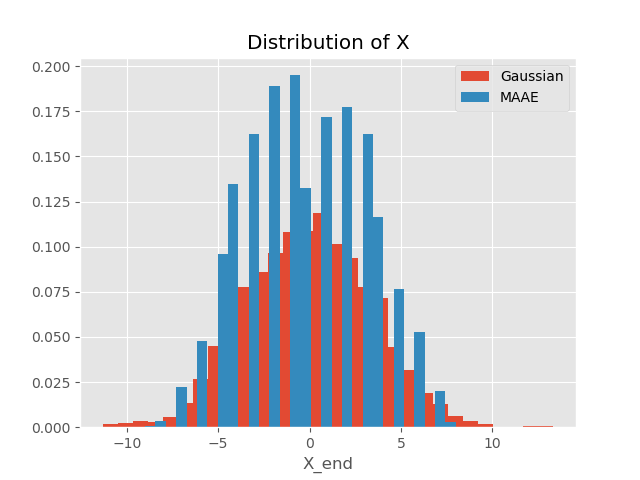

<IPython.core.display.Javascript object>


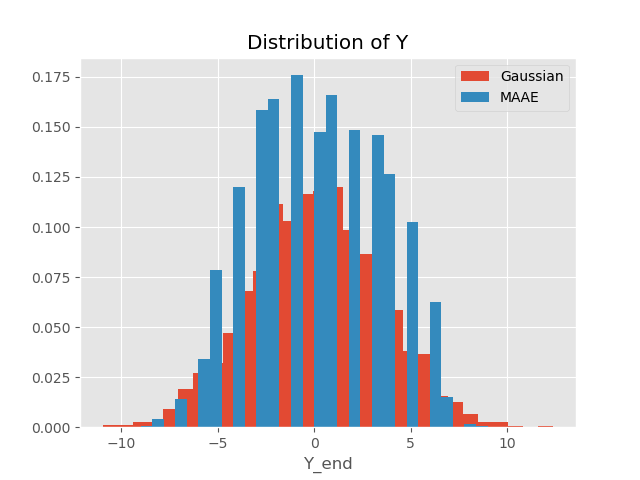

In [13]:
n, d = 2000, 2
end_points = np.zeros((n,d))
for i in range(n):
    m, _, _ = build_maae_l(10, d)
    end_points[i] = m[len(m) - 1]
X, Y = end_points[:, 0], end_points[:, 1]

mean_X = np.mean(X)
std_X = np.std(X)

mean_Y = np.mean(Y)
std_Y = np.std(Y)

#Comparition with a guaussian distribution

bins = 30

plt.figure()
plt.title("Distribution of X")
plt.xlabel("X_end")
plt.hist(np.random.randn(n)*std_X, bins, label="Gaussian", normed=True)
plt.hist(X, bins, label = "MAAE", normed=True)
plt.legend()

plt.figure()
plt.title("Distribution of Y")
plt.xlabel("Y_end")
plt.hist(np.random.randn(n)*std_Y, bins, label = "Gaussian", normed=True)
plt.hist(Y, bins, label = "MAAE", normed = True)
plt.legend()

## Estimators

In [14]:
d = 2 # dimension of walks
N = 100 # number of estimators
n = 1000 # number of walk for each estimator

In [15]:
e1 = EstimatorPlot(mean_d_IS, N, n, d, label = "IS with step generation", color = "red")
e_reject = EstimatorPlot(mean_d_reject_IS, N, n, d, label = "IS with reject", color = "blue")

<IPython.core.display.Javascript object>


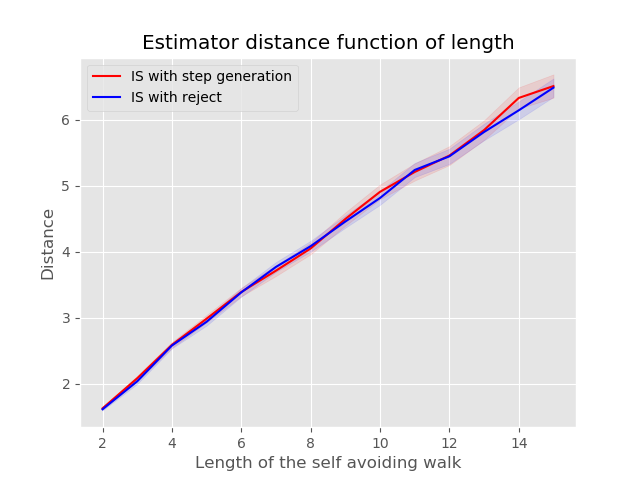

In [16]:
e1.plot_estimator()
e_reject.plot_estimator(figure = False)

<IPython.core.display.Javascript object>


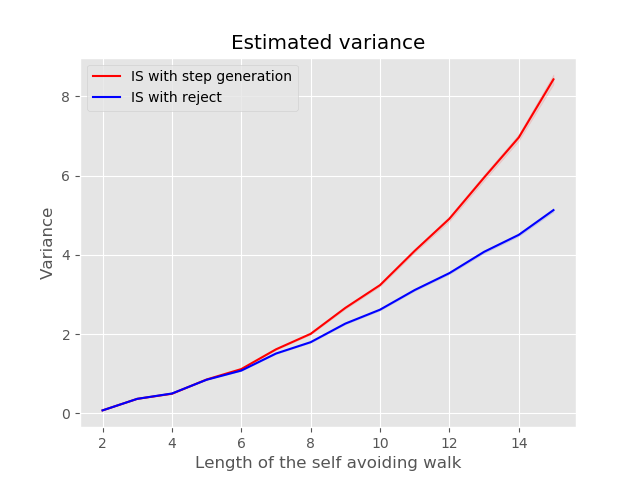

In [17]:
e1.plot_variance()
e_reject.plot_variance(figure = False)

<IPython.core.display.Javascript object>


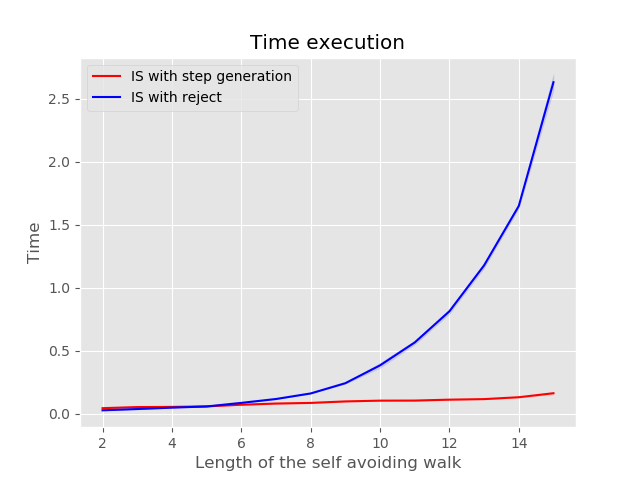

In [18]:
e1.plot_time()
e_reject.plot_time(figure = False)